In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, GRU,LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [129]:
df=pd.read_csv('./INFY.csv',index_col='Date',parse_dates=True)

In [130]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,INFOSYSTCH,EQ,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+12,NaN,NaN,NaN
2000-01-04,INFOSYSTCH,EQ,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+13,NaN,NaN,NaN
2000-01-05,INFOSYSTCH,EQ,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+14,NaN,NaN,NaN
2000-01-06,INFOSYSTCH,EQ,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+14,NaN,NaN,NaN
2000-01-07,INFOSYSTCH,EQ,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,INFY,EQ,1333.80,1332.25,1351.30,1321.00,1345.00,1343.55,1343.19,7088606,9.521361e+14,130375.0,4218129.0,0.5951
2021-04-27,INFY,EQ,1343.55,1346.00,1353.00,1340.15,1347.50,1348.50,1346.89,3636115,4.897445e+14,145974.0,1871084.0,0.5146
2021-04-28,INFY,EQ,1348.50,1358.00,1359.50,1344.60,1355.80,1356.00,1353.45,4879234,6.603778e+14,137376.0,2857134.0,0.5856


In [131]:
df['Date']=df.index

In [132]:
start_date='2020-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [133]:
df=df.loc[mask]

In [134]:
df=df.loc[mask]

In [135]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [136]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [137]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [138]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [139]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (201, 50) Y.shape (201,)


In [140]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

Bi-LSTM

In [141]:
i=Input(shape=(T,1))
x=Bidirectional(LSTM(200,return_sequences=True))(i)
x=Bidirectional(LSTM(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_lstm=Model(i,x)
model_bi_lstm.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 50, 400)          323200    
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 50, 400)          961600    
 onal)                                                           
                                                                 
 global_max_pooling1d_8 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_24 (Dense)            (None, 100)               40100     
                                                           

In [142]:
check_point_bi_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [143]:
model_bi_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [144]:
r=model_bi_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_lstm]
)

Epoch 1/100
4/4 [==============================] - 12s 1s/step - loss: 443.4062 - mae: 14.9696 - mse: 443.4062 - val_loss: 345.8952 - val_mae: 14.8175 - val_mse: 345.8952
Epoch 2/100
4/4 [==============================] - 3s 782ms/step - loss: 441.3260 - mae: 14.8754 - mse: 441.3260 - val_loss: 340.7309 - val_mae: 14.7206 - val_mse: 340.7309
Epoch 3/100
4/4 [==============================] - 3s 738ms/step - loss: 438.7328 - mae: 14.9197 - mse: 438.7328 - val_loss: 341.2754 - val_mae: 14.7415 - val_mse: 341.2754
Epoch 4/100
4/4 [==============================] - 3s 751ms/step - loss: 434.2044 - mae: 14.7932 - mse: 434.2044 - val_loss: 348.0914 - val_mae: 14.8466 - val_mse: 348.0914
Epoch 5/100
4/4 [==============================] - 3s 724ms/step - loss: 431.6457 - mae: 14.7235 - mse: 431.6457 - val_loss: 352.0778 - val_mae: 14.9006 - val_mse: 352.0778
Epoch 6/100
4/4 [==============================] - 3s 754ms/step - loss: 431.1944 - mae: 14.7089 - mse: 431.1944 - val_loss: 354.5666 - v

Bi-directional GRU

In [145]:
i=Input(shape=(T,1))
x=Bidirectional(GRU(200,return_sequences=True))(i)
x=Bidirectional(GRU(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_gru=Model(i,x)
model_bi_gru.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 50, 400)          243600    
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 50, 400)          722400    
 onal)                                                           
                                                                 
 global_max_pooling1d_9 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_27 (Dense)            (None, 100)               40100     
                                                           

In [146]:
check_point_bi_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [147]:
model_bi_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [148]:
r=model_bi_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_gru]
)

Epoch 1/100
4/4 [==============================] - 12s 1s/step - loss: 439.9128 - mae: 14.9023 - mse: 439.9128 - val_loss: 342.2428 - val_mae: 14.7582 - val_mse: 342.2428
Epoch 2/100
4/4 [==============================] - 2s 624ms/step - loss: 443.2548 - mae: 15.0093 - mse: 443.2548 - val_loss: 341.7628 - val_mae: 14.7466 - val_mse: 341.7628
Epoch 3/100
4/4 [==============================] - 2s 601ms/step - loss: 433.2950 - mae: 14.9051 - mse: 433.2950 - val_loss: 344.5930 - val_mae: 14.8151 - val_mse: 344.5930
Epoch 4/100
4/4 [==============================] - 2s 604ms/step - loss: 428.6678 - mae: 14.7144 - mse: 428.6678 - val_loss: 363.7587 - val_mae: 15.0824 - val_mse: 363.7587
Epoch 5/100
4/4 [==============================] - 2s 588ms/step - loss: 428.8305 - mae: 14.7353 - mse: 428.8305 - val_loss: 358.6673 - val_mae: 15.0160 - val_mse: 358.6673
Epoch 6/100
4/4 [==============================] - 2s 597ms/step - loss: 421.9488 - mae: 14.5961 - mse: 421.9488 - val_loss: 349.0332 - v

Predictions

In [149]:
train_idx[:T+1]=False

In [150]:
Ptrain_bi_lstm=model_bi_lstm.predict(Xtrain).flatten()
Ptest_bi_lstm=model_bi_lstm.predict(Xtest).flatten()

In [151]:
Ptrain_bi_gru=model_bi_gru.predict(Xtrain).flatten()
Ptest_bi_gru=model_bi_gru.predict(Xtest).flatten()

In [152]:
df.loc[train_idx,'Diff Bi-LSTM train prediction']=Ptrain_bi_lstm
df.loc[test_idx,'Diff bi-LSTM test prediction']=Ptest_bi_lstm

In [153]:
df.loc[train_idx,'Diff Bi-GRU train prediction']=Ptrain_bi_gru
df.loc[test_idx,'Diff BiGRU test prediction']=Ptest_bi_gru

In [154]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [155]:
last_train=train.iloc[-1]['Prev Close']

In [156]:
df.loc[train_idx,'train_Bi_LSTM']=prev[train_idx]+Ptrain_bi_lstm
df.loc[test_idx,'Prediction_Bi_LSTM']=prev[test_idx]+Ptest_bi_lstm

In [157]:
df.loc[train_idx,'train_Bi_GRU']=prev[train_idx]+Ptrain_bi_gru
df.loc[test_idx,'Prediction_Bi_GRU']=prev[test_idx]+Ptest_bi_gru

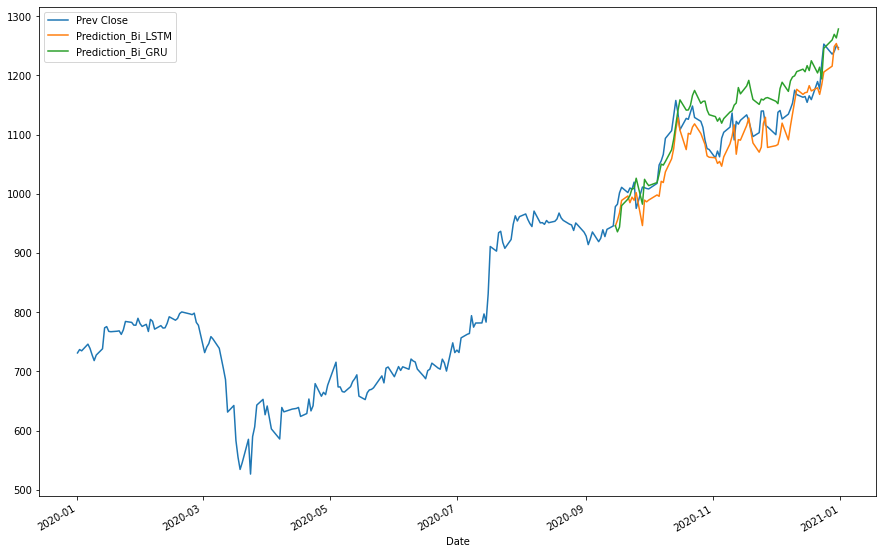

In [158]:
df[[ 'Prev Close','Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

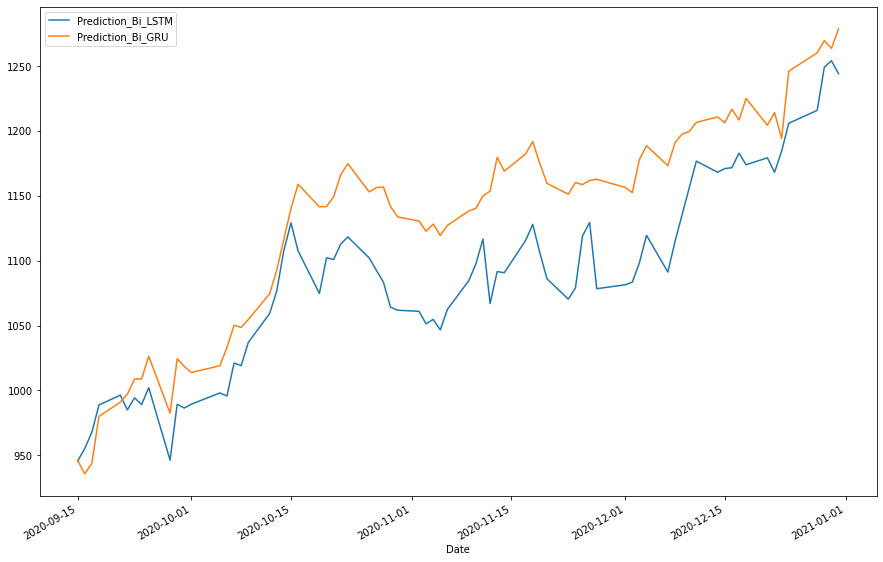

In [159]:
df[[ 'Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

Evaluation

In [160]:
pred_bi_lstm=df['Prediction_Bi_LSTM']
pred_bi_lstm.dropna(inplace=True)

In [161]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_lstm))
print(rmse)

30.478694651014564


In [162]:
error=mean_absolute_error(test['Prev Close'],pred_bi_lstm)
print(error)

25.55262530146042


In [163]:
r2_score(test['Prev Close'],pred_bi_lstm)

0.7905914332135444

In [164]:
pred_bi_gru=df['Prediction_Bi_GRU']
pred_bi_gru.dropna(inplace=True)

In [165]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_gru))
print(rmse)

40.054093028638995


In [166]:
error=mean_absolute_error(test['Prev Close'],pred_bi_gru)
print(error)

34.92993478711446


In [167]:
r2_score(test['Prev Close'],pred_bi_gru)

0.6383441264111832